## 1. Загрузка данных

**Чтение данных, преобразование даты, добавление столбца "Цена"**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


data = pd.read_excel('dataset.xlsx')

# Добавляем столбец с ценой
data['Цена'] = data['Сумма'] / data['Количество']

# Преобразование даты в числовой формат
data['Дата'] = pd.to_datetime(data['Дата'])

## 2. Подготовка рабочего датафрейма

In [2]:
# Группировка по SKU с добавлением суммы объема продаж по каждому SKU в день
groupby_sku = data.groupby(['SKU, Код', 'Дата'])['Количество'].sum().to_frame().reset_index()

# Группировка по SKU с добавлением средней цены для каждого дня
groupby_price = data.groupby(['SKU, Код', 'Дата'])['Цена'].mean().to_frame().reset_index()
groupby_price['Цена'] = round(groupby_price['Цена'])

# Объединение двух таблиц в одну, сортируем по дате
df = groupby_price.merge(groupby_sku, on=['SKU, Код', 'Дата'])
df = df.sort_values(by='Дата', ascending=True)

df.head(5)

,"SKU, Код",Дата,Цена,Количество
0,"Колбаса ""Докторская Как раньше"" 1 кг.ц/ф, РТ-0...",2022-08-01,350.0,81.465
1665,"Колбаса ""Русская"" ГОСТ «Костромские продукты»,...",2022-08-01,500.0,9.442
999,"Колбаса ""Молочная"" ГОСТ «Костромские продукты»...",2022-08-01,508.0,7.243
1998,"Колбаса ""Чайная"" ГОСТ 1 кг,ц/ф, РТ-00001785",2022-08-01,369.0,14.215
2259,"Колбаса ""Чайная"" КР, РТ-00003380",2022-08-01,323.0,6.147


In [3]:
# Вывод статистических показателей по Цене и Количеству
df[['Цена', 'Количество']].describe()

,Цена,Количество
count,5125.000000,5125.000000
mean,381.587902,16.897198
std,69.915059,17.478782
min,255.000000,0.048000
25%,331.000000,4.764000
50%,359.000000,12.211000
75%,456.000000,23.589000
max,640.000000,144.465000


<div class = "alert alert-block alert-info">
    <b> Далее мы будем рассматривать исключительно один SKU (Колбаса"Русская" ГОСТ 1 кг,ц/ф, РТ-00003371) </b>
</div>

In [4]:
# Выделяем в отдельную переменную данные по одному SKU и проверяем ее
test = df[df['SKU, Код'] == 'Колбаса"Русская" ГОСТ 1 кг,ц/ф, РТ-00003371'].sort_values(by='Дата', ascending=True)
test['SKU, Код'].unique()

array(['Колбаса"Русская" ГОСТ 1 кг,ц/ф, РТ-00003371'], dtype=object)

In [5]:
# Добавляем столбцы с имзенением цены и объема относительно предыдущего дня в относительных единицах
# первую строчку с показателем NaN удаляем
test['Изменение цены'] = test['Цена'].pct_change()
test['Изменение продаж'] = test['Количество'].pct_change()
test.dropna(inplace=True)
test.head(5)

,"SKU, Код",Дата,Цена,Количество,Изменение цены,Изменение продаж
4835,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",2022-08-02,456.0,1.376,-0.006536,0.168081
4836,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",2022-08-03,459.0,0.276,0.006579,-0.799419
4837,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",2022-08-04,469.0,0.846,0.021786,2.065217
4838,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",2022-08-05,473.0,2.035,0.008529,1.405437
4839,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",2022-08-06,469.0,0.436,-0.008457,-0.785749


In [6]:
# Вывод статистических показателей по Цене и Количеству
test[['Количество', 'Цена']].describe()

,Количество,Цена
count,289.000000,289.000000
mean,1.375827,471.809689
std,1.123070,47.189722
min,0.048000,389.000000
25%,0.594000,426.000000
50%,1.115000,479.000000
75%,1.716000,519.000000
max,8.307000,519.000000


(array([ 56.,  23.,  11.,  78., 121.]),
 array([389., 415., 441., 467., 493., 519.]),
 <BarContainer object of 5 artists>)

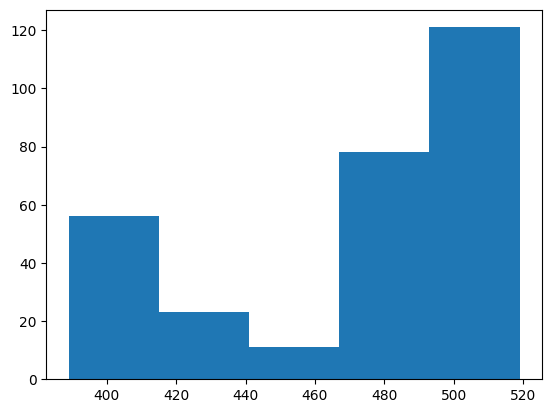

In [7]:
# Строим гистограмму с разбиением на 5 корзин по цене
plt.hist(test['Цена'], bins=5)

## 3. Приступаем к расчету нужных нам показателей и визуализации полученных результатов

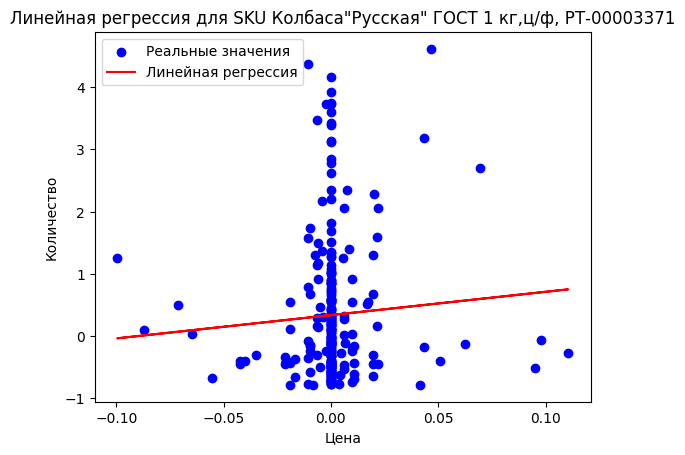

,"SKU, Код",Коэффициент эластичности,Коэффициент линейной регрессии,Коэффициент корреляции,alpha,error,Изменение при увеличении на n руб.,Изменение при уменьшении на n руб.
0,"Колбаса""Русская"" ГОСТ 1 кг,ц/ф, РТ-00003371",3.746,3.746,0.066,0.336,1.111,74.926,-74.926


In [8]:
# Создаем пустой датафрейм для сбора результатов
results = pd.DataFrame(columns=[
    'SKU, Код',
    'Коэффициент эластичности',
    'Коэффициент линейной регрессии',
    'Коэффициент корреляции',
    'alpha',
    'error',
    'Изменение при увеличении на n руб.',
    'Изменение при уменьшении на n руб.'
])

n = 20 # изменение цены (можно менять на другое значение)

# Фильтруем столбец изменения продаж, оставляем значения, которые лежат в диапазоне от 5 до 95 перцинтеля
test = test[test['Изменение продаж'].between(*np.percentile(test['Изменение продаж'], [5, 95]))]


for sku in test['SKU, Код'].unique():
    subset = test[test['SKU, Код'] == sku]
    
    X = subset['Изменение цены'].values.reshape(-1, 1)
    y = subset['Изменение продаж'].values

    # Регрессионный анализ
    reg = LinearRegression().fit(X, y)
    
    # Предсказания модели
    y_pred = reg.predict(X)
    
    # Коэффициент эластичности
    elasticity = reg.coef_[0]
    
    # const
    alpha = reg.intercept_

    # corel
    cor = test['Изменение продаж'].corr(test['Изменение цены'])
    
    # Среднеквадратическая ошибка
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Прогнозирование изменений в объеме продаж при изменении цены на n рублей
    increase_forecast = reg.predict(np.array([[np.mean(X) + n]]))[0] - np.mean(y)
    decrease_forecast = reg.predict(np.array([[np.mean(X) - n]]))[0] - np.mean(y)
    

    # Добавление результатов в датафрейм
    temp_df = pd.DataFrame([{
        'SKU, Код': sku,
        'Коэффициент эластичности': round(elasticity, 3),
        'Коэффициент линейной регрессии': round(reg.coef_[0], 3),
        'Коэффициент корреляции': round(cor, 3),
        'alpha': round(alpha, 3),
        'error': round(rmse, 3),
        'Изменение при увеличении на n руб.':round(increase_forecast, 3),
        'Изменение при уменьшении на n руб.': round(decrease_forecast, 3)
    }])
    
    results = pd.concat([results, temp_df], ignore_index=True)

    plt.scatter(X, y, color='blue', label='Реальные значения')  # реальные данные
    plt.plot(X, y_pred, color='red', label='Линейная регрессия')  # предсказанные данные
    plt.title(f'Линейная регрессия для SKU {sku}')
    plt.xlabel('Цена')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

display(results.head(60))